In [14]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import funcTest as ft
import importlib

from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

from sklearn import tree,naive_bayes,svm,ensemble,neighbors
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
def matrix_conf(test_Y,test_pred,labels=[-1,0,1]):
    cm = confusion_matrix(test_Y,test_pred,labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
    disp.plot()
    return cm

def info_test(estim,score_test_array=False):
    test_res = [100*e.score(test_X,test_Y) for e in estim]
    test_pred = [e.predict(test_X) for e in estim]
    
    max_est = test_res.index(max(test_res)) # cogemos el estimador con maximo score para calcular confusion matrix

    cm = matrix_conf(test_Y,test_pred[max_est])
    
    if score_test_array==True:
        return max(test_res),max_est,cm,test_res
    else:
        return max(test_res),max_est,cm
    
def acc_HDA(cm):
    H = cm[0][0]/sum(cm[0])
    D = cm[1][1]/sum(cm[1])
    A = cm[2][2]/sum(cm[2])
    return H,D,A

## BASELINE DATASET 1 - CUOTAS

In [3]:
path = os.getcwd() + '\\data_train\\'

cuotas = pd.read_csv(path+'DATA1_ProbCuotas.csv');

In [4]:
max(cuotas['B365A'])

0.8849557522123894

#### DUDA
Si por ejemplo escalamos unos datos X entre 0 y 1. Y luego cuando ya tenemos el modelo entrenado y le pasamos unos datos X' para que los prediga, si por ejemplo max(X') >>>> max(X) no se estaria escalando diferente los datos al haber una anomalía?

In [5]:
data = ft.normalDB(cuotas,scaler=Normalizer(norm='l2'))
data

,B365H,B365D,B365A,res
0,0.681186,0.467099,0.563740,1
1,0.383963,0.404172,0.830191,1
2,0.524158,0.451358,0.722173,-1
3,0.918087,0.312150,0.244291,-1
4,0.916745,0.323931,0.233770,-1
...,...,...,...,...
1821,0.894148,0.362130,0.263367,0
1822,0.169386,0.312953,0.934542,0
1823,0.691807,0.506616,0.514532,1
1824,0.856448,0.394417,0.333063,-1


In [6]:
(train_DB,train_X,train_Y,test_X,test_Y) = ft.preprocessDB(data)

### BASELINE 0: ONE CLASS CLASSIFIER

In [7]:
list_tY = list(test_Y)
print(f'De un total de {len(list_tY)} muestras: \n')
print(list_tY.count(0)/len(list_tY)*100)
print(list_tY.count(-1)/len(list_tY)*100)
print(list_tY.count(1)/len(list_tY)*100)

De un total de 274 muestras: 

22.99270072992701
46.35036496350365
30.656934306569344


### BASELINE 1: ARBOL DE DECISIÓN

In [25]:
clf = tree.DecisionTreeClassifier();

In [26]:
param_tree = {
    'splitter' : ['best', 'random'],
#     'max_depth' : [None,5,10],
    'min_samples_split' : [5,50,250],
    'min_samples_leaf' : [2,5,10],
    'random_state' : [None],
    'max_leaf_nodes' : [None,5,10,50,100]
}

In [27]:
resultado = ft.train_wGridSearch(clf,train_X,train_Y,param_tree)

7.143


In [28]:
resultado['test_score']*100

array([56.91318328, 51.76848875, 53.22580645, 53.22580645, 55.80645161])

C:\Users\GuillemUPV\Anaconda3\envs\tfg\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


[56.20437956204379,
 55.1094890510949,
 56.56934306569343,
 56.56934306569343,
 57.299270072992705]

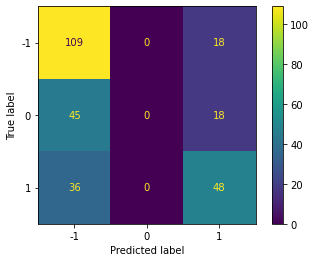

In [29]:
# matriz de confusión del mejor clasificador

(acc,max_ind,matrix,score_test_array) = info_test(resultado['estimator'],score_test_array=True)
score_test_array

In [30]:
acc_HDA(matrix)

(0.8582677165354331, 0.0, 0.5714285714285714)

In [31]:
mejor_clasificador = resultado['estimator'][max_ind].best_estimator_
mejor_clasificador

DecisionTreeClassifier(max_leaf_nodes=100, min_samples_leaf=5,
                       min_samples_split=250, splitter='random')

In [ ]:
ft.tree_png(mejor_clasificador,['-1','0','1'],train_X.columns)

### BASELINE 2: NAIVE-BAYES

In [66]:
res = ft.train_wCrossVal(naive_bayes.GaussianNB(),train_X,train_Y)

0.021


In [68]:
res['test_score']*100

array([58.19935691, 50.80385852, 54.19354839, 53.5483871 , 54.51612903])

C:\Users\GuillemUPV\Anaconda3\envs\tfg\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


([55.1094890510949,
  55.47445255474452,
  55.1094890510949,
  55.1094890510949,
  54.379562043795616],
 1)

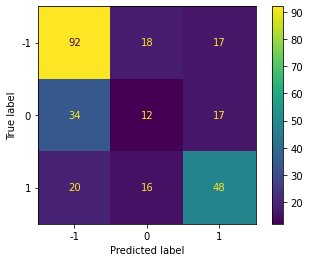

In [70]:
(acc,max_ind,cm,score_test_array) = info_test(res['estimator'],score_test_array=True)
score_test_array,max_ind  # representa array con los test para cada estimador, y el indice del mejor estimador

In [71]:
acc_HDA(cm)

(0.7244094488188977, 0.19047619047619047, 0.5714285714285714)

### BASELINE 3: SVM

In [82]:
clf = svm.SVC()

In [99]:
param_svm = {
    'C' : [10,1000],
    'kernel' : ['linear','poly'],
    'degree' : [2,4],
    'gamma' : ['scale','auto'],
    'coef0' : [0.0,5.0]
}

In [93]:
param_svm = {
    'C' : [1,10],
    'kernel' : ['rbf'],
    'gamma' : ['scale','auto'],
}

In [100]:
res = ft.train_wGridSearch(clf,train_X,train_Y,param_svm)

2756.124


In [101]:
res['test_score']

array([0.55948553, 0.54019293, 0.54193548, 0.53548387, 0.5483871 ])

C:\Users\GuillemUPV\Anaconda3\envs\tfg\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


(58.3941605839416,
 2,
 [57.66423357664233,
  58.02919708029197,
  58.3941605839416,
  57.66423357664233,
  57.66423357664233])

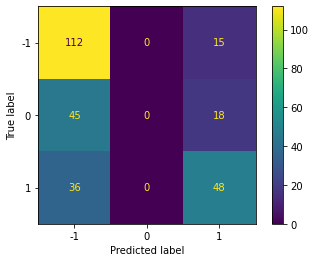

In [102]:
(acc,max_ind,cm,score_test_array) = info_test(res['estimator'],score_test_array=True)
acc,max_ind,score_test_array

In [103]:
acc_HDA(cm)

(0.8818897637795275, 0.0, 0.5714285714285714)

In [105]:
res['estimator'][2].best_estimator_.coef0

0.0

### BASELINE 4: BAGGING

#### BAGGING CON K-VECINOS

In [169]:
clf = ensemble.BaggingClassifier(neighbors.KNeighborsClassifier(),
                                 n_estimators=3,max_samples=0.75,n_jobs=-1)

In [170]:
params_bag = {
    'base_estimator__n_neighbors' : [5,10,50,100],
    'base_estimator__weights' : ['uniform','distance'],
}

In [171]:
clf.get_params().keys()

dict_keys(['base_estimator__algorithm', 'base_estimator__leaf_size', 'base_estimator__metric', 'base_estimator__metric_params', 'base_estimator__n_jobs', 'base_estimator__n_neighbors', 'base_estimator__p', 'base_estimator__weights', 'base_estimator', 'bootstrap', 'bootstrap_features', 'max_features', 'max_samples', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [172]:
res = ft.train_wGridSearch(clf,train_X,train_Y,param=params_bag,return_train_score=True)

5.667


In [173]:
res['test_score']

array([0.54983923, 0.52411576, 0.52903226, 0.5516129 , 0.52258065])

C:\Users\GuillemUPV\Anaconda3\envs\tfg\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


(56.20437956204379,
 4,
 [55.47445255474452,
  55.839416058394164,
  55.839416058394164,
  55.1094890510949,
  56.20437956204379])

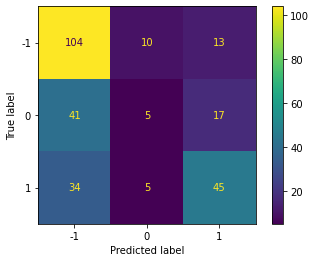

In [174]:
(acc,max_ind,cm,score_test_array) = info_test(res['estimator'],score_test_array=True)
acc,max_ind,score_test_array

In [175]:
acc_HDA(cm)

(0.8188976377952756, 0.07936507936507936, 0.5357142857142857)

In [ ]:
res['estimator'][max_ind].best_estimator_.base_estimator.get_params()

#### BAGGING con Árbol de decisión

In [178]:
clf = ensemble.BaggingClassifier(tree.DecisionTreeClassifier(),
                                 n_estimators=3,max_samples=0.75,n_jobs=-1)

In [179]:
clf.get_params().keys()

dict_keys(['base_estimator__ccp_alpha', 'base_estimator__class_weight', 'base_estimator__criterion', 'base_estimator__max_depth', 'base_estimator__max_features', 'base_estimator__max_leaf_nodes', 'base_estimator__min_impurity_decrease', 'base_estimator__min_impurity_split', 'base_estimator__min_samples_leaf', 'base_estimator__min_samples_split', 'base_estimator__min_weight_fraction_leaf', 'base_estimator__random_state', 'base_estimator__splitter', 'base_estimator', 'bootstrap', 'bootstrap_features', 'max_features', 'max_samples', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [180]:
param_tree = {
    'n_estimators' : [3,5,10],
    'base_estimator__splitter' : ['best', 'random'],
    'base_estimator__min_samples_split' : [5,50,250],
    'base_estimator__min_samples_leaf' : [2,5,10],
    'base_estimator__random_state' : [None],
    'base_estimator__max_leaf_nodes' : [None,5,10,50,100]
}

In [181]:
res = ft.train_wGridSearch(clf,train_X,train_Y,param_tree,cv=5,return_train_score=True)

4788.163


In [182]:
res['test_score']

array([0.55948553, 0.54662379, 0.53225806, 0.53548387, 0.55806452])

C:\Users\GuillemUPV\Anaconda3\envs\tfg\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


(57.299270072992705,
 2,
 [56.934306569343065,
  56.934306569343065,
  57.299270072992705,
  56.934306569343065,
  56.56934306569343])

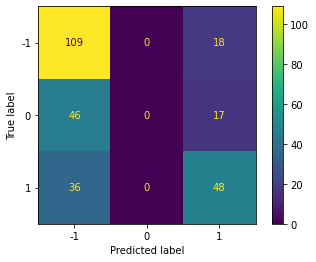

In [183]:
(acc,max_ind,cm,score_test_array) = info_test(res['estimator'],score_test_array=True)
acc,max_ind,score_test_array

In [184]:
acc_HDA(cm)

(0.8582677165354331, 0.0, 0.5714285714285714)

### BASELINE 5: RANDOM FOREST

In [52]:
clf = ensemble.RandomForestClassifier(n_jobs=-1)

In [63]:
params_randfor = {
    'n_estimators' : [200,1000],
    'max_depth' : [5,10],
    'min_samples_split' : [5,50,250],
    'min_samples_leaf' : [2,5,50],
    'max_leaf_nodes' : [None,3,10]
}

In [64]:
res = ft.train_wGridSearch(clf,train_X,train_Y,params_randfor)

1382.837


In [65]:
res['test_score']

array([0.54983923, 0.54983923, 0.53548387, 0.54516129, 0.56451613])

C:\Users\GuillemUPV\Anaconda3\envs\tfg\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


(56.934306569343065,
 3,
 [55.47445255474452,
  55.47445255474452,
  56.20437956204379,
  56.934306569343065,
  56.934306569343065])

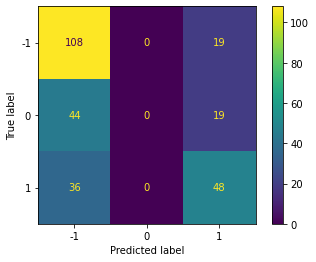

In [66]:
(acc,max_ind,cm,score_test_array) = info_test(res['estimator'],score_test_array=True)
acc,max_ind,score_test_array

In [67]:
acc_HDA(cm)

(0.8503937007874016, 0.0, 0.5714285714285714)

In [68]:
res['estimator'][max_ind].best_estimator_

RandomForestClassifier(max_depth=10, max_leaf_nodes=3, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=200, n_jobs=-1)

### BASELINE 6: ADA BOOST

In [185]:
clf = ensemble.AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier())

In [186]:
clf.base_estimator

DecisionTreeClassifier()

In [187]:
params_ada = {
    'n_estimators' : [10,50,200],
    'learning_rate' : [0.2,1.0,5.0],
    'base_estimator__max_depth' : [1,5,10],
    'base_estimator__min_samples_split' : [5,50,250],
    'base_estimator__min_samples_leaf' : [2,5,50],
    'base_estimator__max_leaf_nodes' : [None,3,10]
}

In [188]:
res = ft.train_wGridSearch(clf,train_X,train_Y,params_ada,cv=3)

1608.094


In [189]:
res['test_score']

array([0.55305466, 0.53376206, 0.52903226, 0.53548387, 0.55483871])

C:\Users\GuillemUPV\Anaconda3\envs\tfg\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


(56.934306569343065,
 2,
 [53.64963503649635,
  56.20437956204379,
  56.934306569343065,
  54.01459854014598,
  56.934306569343065])

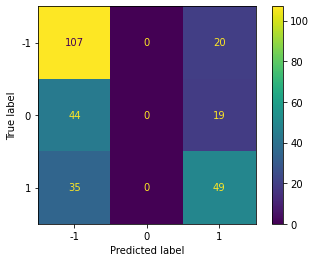

In [190]:
(acc,max_ind,cm,score_test_array) = info_test(res['estimator'],score_test_array=True)
acc,max_ind,score_test_array

In [191]:
acc_HDA(cm)

(0.84251968503937, 0.0, 0.5833333333333334)

In [192]:
mejor_clasificador = res['estimator'][max_ind].best_estimator_
mejor_clasificador

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                         max_leaf_nodes=3,
                                                         min_samples_leaf=2,
                                                         min_samples_split=5),
                   learning_rate=0.2, n_estimators=10)

In [193]:
mejor_clasificador.base_estimator.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': 3,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

### BASELINE 7: GRADIANT BOOSTING DECISION TREE

In [131]:
clf = ensemble.GradientBoostingClassifier()

In [151]:
params_gb = {
#     'loss' : ['deviance','exponential'],
    'learning_rate' : [0.02,0.1,0.5,2],
    'n_estimators' : [100,500],
    'min_samples_split' : [0.05,0.1],
    'min_samples_leaf' : [10,50],
    'max_depth' : [1,3],
    'max_leaf_nodes' : [3,10],
    'tol':[0.001]
}

In [152]:
res = ft.train_wGridSearch(clf,train_X,train_Y,params_gb)

2297.948


In [153]:
res['test_score']

array([0.55305466, 0.53054662, 0.53548387, 0.53870968, 0.55483871])

C:\Users\GuillemUPV\Anaconda3\envs\tfg\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[-1, 0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


(57.66423357664233,
 3,
 [55.47445255474452,
  55.839416058394164,
  56.934306569343065,
  57.66423357664233,
  56.934306569343065])

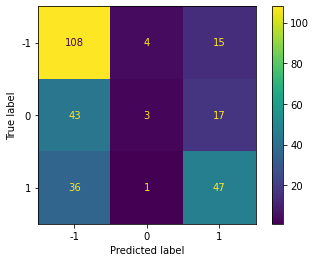

In [154]:
(acc,max_ind,cm,score_test_array) = info_test(res['estimator'],score_test_array=True)
acc,max_ind,score_test_array

In [155]:
acc_HDA(cm)

(0.8503937007874016, 0.047619047619047616, 0.5595238095238095)

In [158]:
mejor_clasificador = res['estimator'][max_ind].best_estimator_
mejor_clasificador

GradientBoostingClassifier(learning_rate=0.02, max_leaf_nodes=10,
                           min_samples_leaf=10, min_samples_split=0.05,
                           tol=0.001)

In [157]:
mejor_clasificador.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.02,
 'loss': 'deviance',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': 3,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 50,
 'min_samples_split': 0.05,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}